In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
import numpy as np
import os
from torch.utils import data

## Dataloader

In [297]:
class ImageDataLoader(data.Dataset):
    "My own Image Loader made to read .npy images"

    def __init__(self, directory, transform=None):

        self.directory = directory
        self.transform = transform
        self.file_names = [
            file
            for file in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, file))
        ]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):

        img_path = os.path.join(self.directory, self.file_names[idx])
        image = np.load(img_path)
        image = image.astype(np.float32)

        if self.transform is not None:
            image = self.transform(image)

        image_labels = torch.zeros(image.shape[0])
        return image, image_labels


class ToTensorWithScaling:
    def __init__(self, min_val: float = 0.0, max_val: float = 1.0, eps: float = 1e-6):
        self.min_val = min_val
        self.max_val = max_val
        self.eps = eps

    def __call__(self, image: np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        # Get min and max values for every channel
        min_vals = image.amin(dim=(1, 2), keepdim=True)
        max_vals = image.amax(dim=(1, 2), keepdim=True)

        # [0, 1]
        image = (image - min_vals) / (max_vals - min_vals + self.eps)

        # [min_val, max_val]
        image = image * (self.max_val - self.min_val) + self.min_val

        # # rescale to 28 x 28
        # image = torch.nn.functional.interpolate(
        #     image.unsqueeze(0), (28, 28), mode="bilinear", align_corners=False
        # )
        # keep only 1 channel but keep the dimension
        # image = image.squeeze(0)[0].unsqueeze(0)

        return image

In [298]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 32

PATH_TEST_TYPICAL = "../dataset/test_typical"
PATH_TEST_NOVEL = "../dataset/test_novel/all"

RANDOM_SEED = 42

PATH_TRAIN = "../dataset/train_typical"
PATH_VALIDATION = "../dataset/validation_typical"

transform = ToTensorWithScaling(-1.0, 1.0)

# print(model_name, lr, epoch_number, device)

train_dataset = ImageDataLoader(PATH_TRAIN, transform=transform)
validation_dataset = ImageDataLoader(PATH_VALIDATION, transform=transform)

test_typical_dataset = ImageDataLoader(PATH_TEST_TYPICAL, transform=transform)
test_novel_dataset = ImageDataLoader(PATH_TEST_NOVEL, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

test_typical_loader = DataLoader(test_typical_dataset, batch_size=1)
test_novel_loader = DataLoader(test_novel_dataset, batch_size=1)

In [106]:
# verify that the data has no missing value
for i, (image, label) in enumerate(train_loader):
    if torch.isnan(image).any():
        print("Found missing value")
        break

# verify that data is in the correct range
for i, (image, label) in enumerate(train_loader):
    if torch.any(image < 0) or torch.any(image > 1.0):
        print("Found value outside of [0, 1]")
        break

## VAE Model definition

In [170]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.nn.functional as F

pyro.enable_validation(False)


class VEncoder(nn.Module):
    """Encoder for VAE."""

    input_to_hidden: nn.Linear
    hidden_to_mu: nn.Linear
    hidden_to_sigma: nn.Linear
    N: torch.distributions.Normal
    kl: float

    def __init__(
        self,
        n_input_features: int,
        n_hidden_neurons: int,
        n_latent_features: int,
    ):
        """
        :param n_input_features: number of input features (28 x 28 = 784 for MNIST)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_latent_features: size of the latent vector
        """
        super().__init__()

        # TU WPISZ KOD
        self.input_to_hidden = nn.Linear(n_input_features, n_hidden_neurons)
        self.hidden_to_mu = nn.Linear(n_hidden_neurons, n_latent_features)
        self.hidden_to_sigma = nn.Linear(n_hidden_neurons, n_latent_features)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Encode data to gaussian distribution params."""

        # TU WPISZ KOD
        x = F.relu(self.input_to_hidden(x))
        z_loc = self.hidden_to_mu(x)
        # exponential activation to ensure the result is positive
        # z_scale = torch.exp(self.hidden_to_sigma(x))
        z_scale = self.hidden_to_sigma(x).exp()

        return z_loc, z_scale


class VDecoder(nn.Module):
    """Decoder for VAE."""

    def __init__(
        self,
        n_latent_features: int,
        n_hidden_neurons: int,
        n_output_features: int,
    ):
        """
        :param n_latent_features: number of latent features (same as in Encoder)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_output_features: size of the output vector (28 x 28 = 784 for MNIST)
        """
        super().__init__()
        # TU WPISZ KOD
        self.latent_to_hidden = nn.Linear(n_latent_features, n_hidden_neurons)
        self.hidden_to_output = nn.Linear(n_hidden_neurons, n_output_features)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to image."""
        # TU WPISZ KOD
        r = F.relu(self.latent_to_hidden(z))
        r = torch.sigmoid(self.hidden_to_output(r))
        return r


class BaseAutoEncoder(nn.Module):
    """Base AutoEncoder module class."""

    def __init__(self, encoder: nn.Module, decoder: nn.Module, n_latent_features: int):
        """
        :param encoder: encoder network
        :param decoder: decoder network
        :param n_latent_features: number of latent features in the AE
        """
        super().__init__()

        self.n_latent_features: int = n_latent_features

        self.encoder: nn.Module = encoder
        self.decoder: nn.Module = decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward function for mapping input to output."""
        z = self.encoder_forward(x)
        return self.decoder_forward(z)

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.

        takes: tensor of shape [batch_size x input_flattened_size] (flattened input)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        raise NotImplementedError()

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.

        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x output_flattened_size] (flettened output)
        """
        raise NotImplementedError()


class VariationalAutoencoder(BaseAutoEncoder):
    """Variational Auto Encoder model."""

    N: torch.distributions.Normal
    kl: float

    def __init__(
        self,
        n_data_features: int,
        n_encoder_hidden_features: int,
        n_decoder_hidden_features: int,
        n_latent_features: int,
    ):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        """
        encoder = VEncoder(
            n_input_features=n_data_features,
            n_hidden_neurons=n_encoder_hidden_features,
            n_latent_features=n_latent_features,
        )
        decoder = VDecoder(
            n_latent_features=n_latent_features,
            n_hidden_neurons=n_decoder_hidden_features,
            n_output_features=n_data_features,
        )
        super().__init__(
            encoder=encoder, decoder=decoder, n_latent_features=n_latent_features
        )
        self.input_shape = None

        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.
        takes: tensor of shape [batch_size x [image-size]] (input images batch)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        # print(x)
        # print(x.shape)

        if self.input_shape is None:
            self.input_shape = x.shape[1:]
        x = x.view(x.shape[0], -1)

        z_loc, z_scale = self.encoder(x)
        z = z_loc + z_scale * self.N.sample(z_loc.shape)

        return z

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.
        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x [image-size]] (reconstructed images batch)
        """
        r = self.decoder(z)
        return r.view(-1, *self.input_shape)

    def model(self, x: torch.Tensor):
        """Pyro model for VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features))
            z_scale = torch.ones((x.shape[0], self.n_latent_features))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for VAE; q(z|x)"""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


class BetaVariationalAutoencoder(VariationalAutoencoder):
    """beta-Variational Auto Encoder model."""

    def __init__(self, beta: float, **kwargs):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        :param beta: regularization coefficient
        """
        super().__init__(**kwargs)
        self.beta = beta

    def model(self, x: torch.Tensor):
        """Pyro model for beta-VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features))
            z_scale = torch.ones((x.shape[0], self.n_latent_features))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for beta-VAE; q(z|x)."""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            with poutine.scale(scale=self.beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

## Train function:

In [299]:
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from torchmetrics import Metric
from tqdm.auto import tqdm, trange

MetricType = Dict[str, List[float]]


def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
) -> Tuple[BaseAutoEncoder, MetricType, MetricType]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training

            # print(inputs)
            # print(inputs.shape)

            # check if contains nan

            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()
            optimizer.step()

            # print("inputs shape: ", inputs.shape)
            # print("rec shape: ", reconstructions.shape)

            if torch.isnan(reconstructions).any():
                print("rec nan found")
                print(reconstructions)
                # check if all values are nan
                if torch.isnan(reconstructions).all():
                    print("all values are nan")
                    # continue
                # continue

            if torch.isnan(inputs).any():
                print("nan found")

            # print("input shape: ", inputs.shape)
            # print("rec shape: ", reconstructions.shape)

            train_metrics["loss"].append(loss.item() / inputs.shape[0])
            train_metrics["mse"].append(
                mean_squared_error(
                    inputs.detach().view(inputs.shape[0], -1),
                    reconstructions.detach().view(reconstructions.shape[0], -1),
                )
            )
            train_metrics["step"].append(global_step)

            # print("loss: ", loss.item() / inputs.shape[0])

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        val_metrics["loss"].append(val_loss.item() / total)
        val_metrics["mse"].append(
            mean_squared_error(
                inputs.view(inputs.shape[0], -1),
                reconstructions.view(reconstructions.shape[0], -1),
            )
        )
        val_metrics["step"].append(global_step)

        print(
            f"Epoch: {epoch}, ",
            f"Train loss: {train_metrics['loss'][-1]}",
            f"Val loss: {val_metrics['loss'][-1]}",
            f"Train MSE: {train_metrics['mse'][-1]}",
        )

    plot_metrics(train_metrics, val_metrics)
    return model, train_metrics, val_metrics


def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    plt.show()
    plt.show()

## train function with gradient norm

In [267]:
from typing import Any, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange


def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
    clip_value: float = 0.5,  # Add clip_value parameter
) -> Tuple[BaseAutoEncoder, dict, dict]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :param clip_value: maximum value to clip gradients
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
        "gradient_norm": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training

            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Compute and log gradient norms
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm**0.5

            train_metrics["gradient_norm"].append(total_norm)

            optimizer.step()

            if torch.isnan(reconstructions).any():
                print("rec nan found")
            if torch.isnan(inputs).any():
                print("nan found")

            loss = loss.item() / inputs.shape[0]
            mse = mean_squared_error(
                inputs.detach().view(inputs.shape[0], -1),
                reconstructions.detach().view(reconstructions.shape[0], -1),
            )
            train_metrics["loss"].append(loss)
            train_metrics["mse"].append(mse)
            train_metrics["step"].append(global_step)

            print("loss: ", loss)
            print("mse: ", mse)
            print("grad norm: ", total_norm)

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        val_metrics["loss"].append(val_loss.item() / total)
        val_metrics["mse"].append(
            mean_squared_error(
                inputs.view(inputs.shape[0], -1),
                reconstructions.view(reconstructions.shape[0], -1),
            )
        )
        val_metrics["step"].append(global_step)

    plot_metrics(train_metrics, val_metrics)
    return model, train_metrics, val_metrics


def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax3.plot(
        train_metrics["step"], train_metrics["gradient_norm"], label="gradient norm"
    )

    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax3.set_ylabel("Gradient Norm")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    ax3.grid()
    ax3.legend()
    plt.show()

## Run Train

In [322]:
# from train_vae_mnist import train_ae as train_ae

pyro.enable_validation(False)

epochs = 10

n_data_features = 64 * 64 * 6
n_hidden_features = 512
n_latent_features = 64
lr = 0.000005


results = []

vae_model = VariationalAutoencoder(
    n_data_features=n_data_features,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,  # how many features will be used to represent input
)

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
loss_fn_args = (vae_model.model, vae_model.guide)
print(f"\n{n_latent_features=}, {n_hidden_features=}, {lr=}")

res_model, train_metrics, val_metrics = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
    # clip_value=500000,
)


n_latent_features=64, n_hidden_features=512, lr=5e-06


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [287]:
def display_reproductions(model, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    with torch.no_grad():
        for i in range(n):
            for input, _ in loader:
                inputs.append(input)
                reconstructions.append(model(input))

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):

        rec = reconstructions[i][0].squeeze(0)
        print(rec.shape)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(rec)
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])


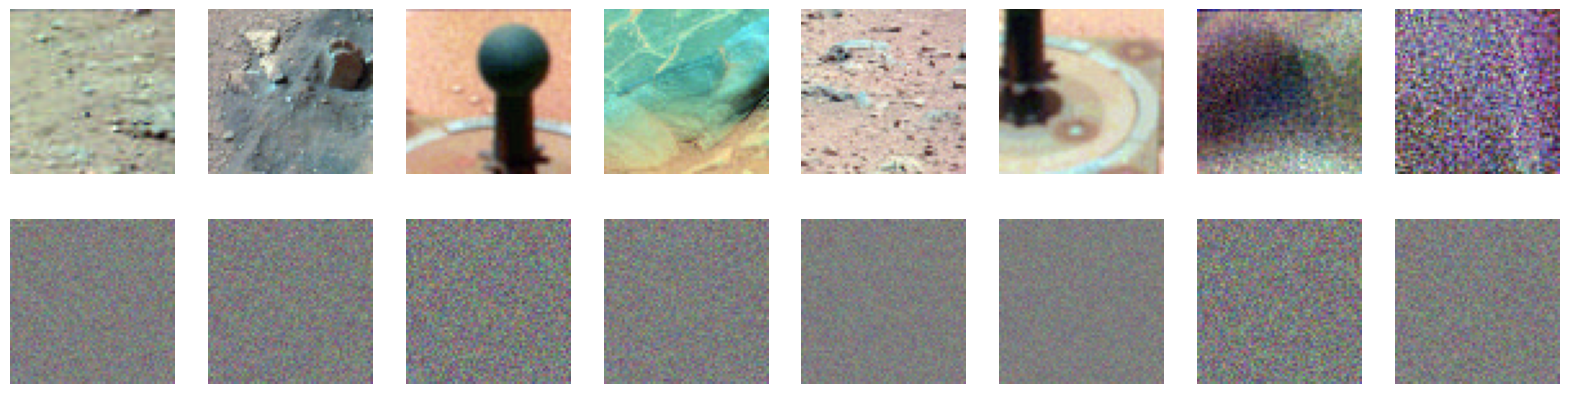

In [302]:
display_reproductions(vae_model, test_typical_loader, n=8)

torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])
torch.Size([6, 64, 64])


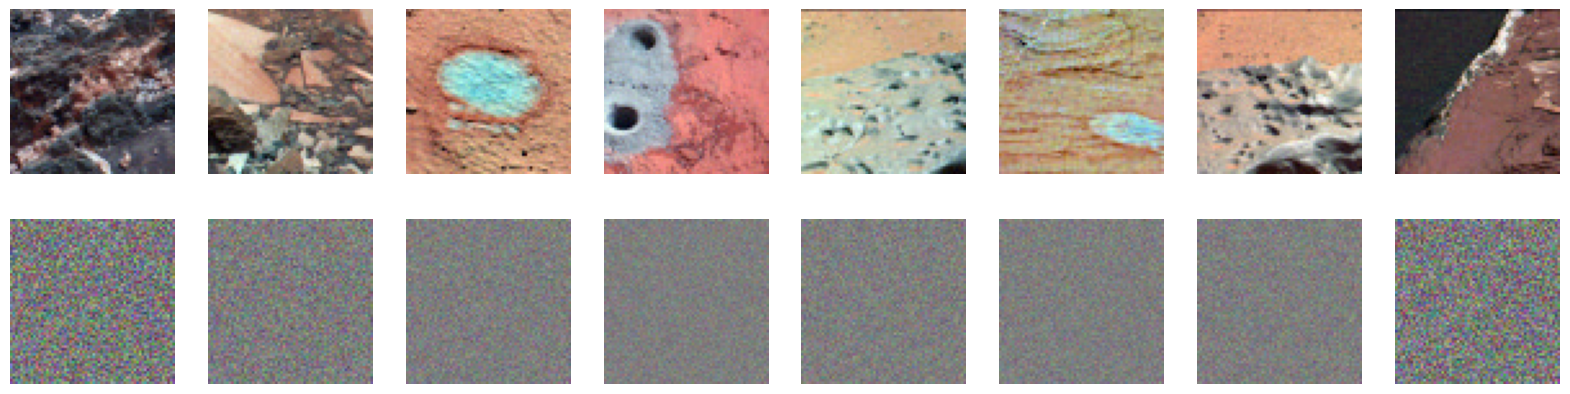

In [303]:
display_reproductions(vae_model, test_novel_loader, n=8)

In [319]:
import torch

# save the model
torch.save(vae_model.state_dict(), "vae_model-full-e-4.pth")

In [320]:
# load the model
vae_model_loaded = VariationalAutoencoder(
    n_data_features=64 * 64 * 6,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,
)
vae_model_loaded.load_state_dict(torch.load("vae_model-full-e-4.pth"))

RuntimeError: Error(s) in loading state_dict for VariationalAutoencoder:
	size mismatch for encoder.input_to_hidden.weight: copying a param with shape torch.Size([128, 784]) from checkpoint, the shape in current model is torch.Size([128, 24576]).
	size mismatch for encoder.hidden_to_mu.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([50, 128]).
	size mismatch for encoder.hidden_to_mu.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for encoder.hidden_to_sigma.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([50, 128]).
	size mismatch for encoder.hidden_to_sigma.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for decoder.latent_to_hidden.weight: copying a param with shape torch.Size([128, 10]) from checkpoint, the shape in current model is torch.Size([128, 50]).
	size mismatch for decoder.hidden_to_output.weight: copying a param with shape torch.Size([784, 128]) from checkpoint, the shape in current model is torch.Size([24576, 128]).
	size mismatch for decoder.hidden_to_output.bias: copying a param with shape torch.Size([784]) from checkpoint, the shape in current model is torch.Size([24576]).

## Different VAE implementation

In [304]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith("1.9.1")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

# Define the image dimensions
image_height, image_width, num_channels = 64, 64, 6
n_data_features = image_height * image_width * num_channels


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_data_features)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.n_data_features = n_data_features

    def forward(self, z):
        # define the forward computation on the latent z
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        # if torch.isnan(loc_img).any():
        #     print("NaN detected in Decoder output")
        # else:
        #     print("No NaN detected in Decoder output")
        return loc_img


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_data_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.n_data_features = n_data_features

    def forward(self, x):
        x = x.reshape(-1, self.n_data_features)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))  # Ensure z_scale is always positive
        # if torch.isnan(z_loc).any() or torch.isnan(z_scale).any():
        #     print("NaN detected in Encoder output")
        # else:
        #     print("No NaN detected in Encoder output")
        return z_loc, z_scale


class VAE(nn.Module):
    n_data_features: int

    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=False,
        n_data_features: int = n_data_features,
    ):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, n_data_features)
        self.decoder = Decoder(z_dim, hidden_dim, n_data_features)
        self.n_data_features = n_data_features

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img).to_event(1),
                obs=x.reshape(-1, self.n_data_features),
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        if torch.isnan(loc_img).any():
            print("NaN detected in reconstructed image")
        return loc_img

In [306]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    # step = 0
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        # step += 1
        # print("StopIteration", step)
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 5.0)
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.0
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [307]:
# Run options
LEARNING_RATE = 1.0e-6
USE_CUDA = False
NUM_EPOCHS = 5
TEST_FREQUENCY = 5
# train_loader, val_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
# vae = VAE(use_cuda=USE_CUDA, n_data_features=64 * 64 * 6)
vae = VAE(use_cuda=USE_CUDA, n_data_features=64 * 64 * 6)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, val_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 17349.1681
[epoch 000] average test loss: 16886.3274
[epoch 001]  average training loss: 16667.9757
[epoch 002]  average training loss: 16048.6420
[epoch 003]  average training loss: 15394.0835
[epoch 004]  average training loss: 14647.2227


In [311]:
def display_reproductions_2(model: VAE, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    with torch.no_grad():
        for i in range(n):
            for input, _ in loader:
                inputs.append(input)
                reconstructions.append(model.reconstruct_img(input))

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):

        rec = reconstructions[i][0].squeeze(0)
        print(rec.shape)
        rec = rec.view(6, 64, 64)
        print(rec.shape)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(rec)
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])
torch.Size([24576])
torch.Size([6, 64, 64])


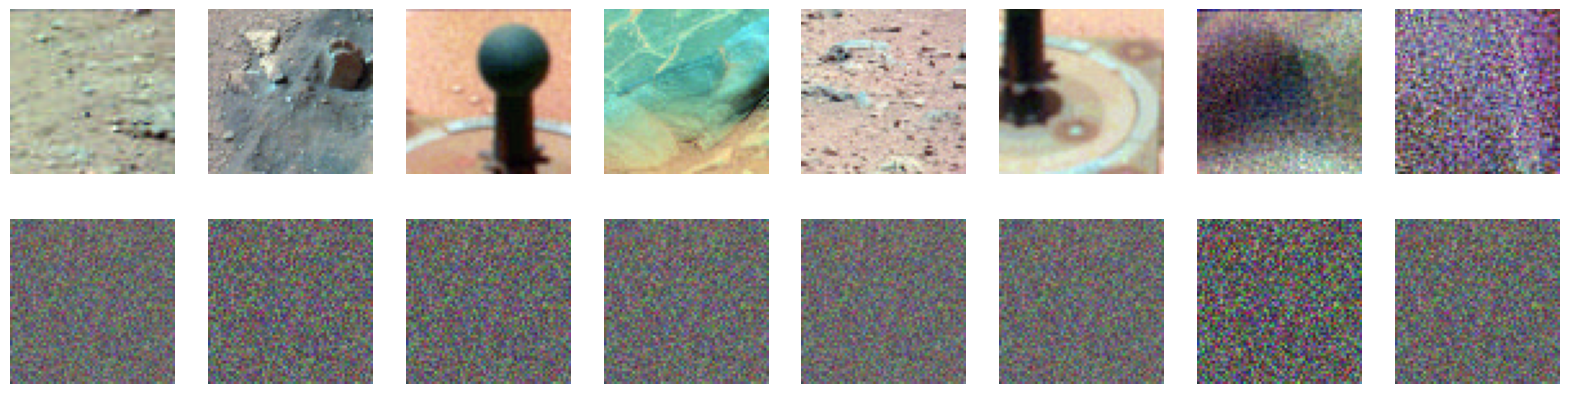

In [312]:
display_reproductions_2(vae, test_typical_loader, n=8)